# ML Pipeline Preparation
Follow the instructions below to help you create your ML pipeline.
### 1. Import libraries and load data from database.
- Import Python libraries
- Load dataset from database with [`read_sql_table`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_sql_table.html)
- Define feature and target variables X and Y

In [2]:
# import libraries
import pandas as pd
from sqlalchemy import create_engine
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.pipeline import Pipeline
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, precision_recall_fscore_support, f1_score, make_scorer
from scipy.stats import gmean
import re
import pickle
import numpy as np

import nltk
nltk.download(['punkt', 'wordnet', 'averaged_perceptron_tagger'])

[nltk_data] Downloading package punkt to /Users/Utyubayev/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/Utyubayev/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/Utyubayev/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [3]:
# load data from database
engine = create_engine('sqlite:///data/Disaster_response.db')
df = pd.read_sql_table('Messages', engine)
engine.dispose()

In [4]:
df.head()

,id,message,original,genre,related,request,offer,aid_related,medical_help,medical_products,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,2,Weather update - a cold front from Cuba that c...,Un front froid se retrouve sur Cuba ce matin. ...,direct,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,7,Is the Hurricane over or is it not over,Cyclone nan fini osinon li pa fini,direct,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,8,Looking for someone but no name,"Patnm, di Maryani relem pou li banm nouvel li ...",direct,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,9,UN reports Leogane 80-90 destroyed. Only Hospi...,UN reports Leogane 80-90 destroyed. Only Hospi...,direct,1.0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,12,"says: west side of Haiti, rest of the country ...",facade ouest d Haiti et le reste du pays aujou...,direct,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
X = df['message']
Y = df[df.columns.to_list()[4:]]
print(X.shape)
print(Y.shape)

(26039,)
(26039, 35)


In [6]:
X.head()

0    Weather update - a cold front from Cuba that c...
1              Is the Hurricane over or is it not over
2                      Looking for someone but no name
3    UN reports Leogane 80-90 destroyed. Only Hospi...
4    says: west side of Haiti, rest of the country ...
Name: message, dtype: object

In [7]:
X.isnull().sum()

0

In [9]:
Y.head()

,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,water,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Data exploration 

In [13]:
sums_categories = Y.sum(axis=0).sort_values(ascending=False)
print(sums_categories)

related                   19953.0
aid_related               10786.0
weather_related            7250.0
direct_report              5034.0
request                    4439.0
other_aid                  3425.0
food                       2906.0
earthquake                 2441.0
storm                      2433.0
shelter                    2295.0
floods                     2145.0
medical_help               2071.0
infrastructure_related     1695.0
water                      1655.0
other_weather              1362.0
buildings                  1325.0
medical_products           1300.0
transport                  1193.0
death                      1186.0
other_infrastructure       1145.0
refugees                    869.0
military                    854.0
search_and_rescue           723.0
money                       601.0
electricity                 529.0
cold                        520.0
security                    469.0
clothing                    399.0
aid_centers                 306.0
missing_people

In [15]:
print(list(sums_categories.index))

['related', 'aid_related', 'weather_related', 'direct_report', 'request', 'other_aid', 'food', 'earthquake', 'storm', 'shelter', 'floods', 'medical_help', 'infrastructure_related', 'water', 'other_weather', 'buildings', 'medical_products', 'transport', 'death', 'other_infrastructure', 'refugees', 'military', 'search_and_rescue', 'money', 'electricity', 'cold', 'security', 'clothing', 'aid_centers', 'missing_people', 'hospitals', 'fire', 'tools', 'shops', 'offer']


Matplotlib is building the font cache; this may take a moment.


<AxesSubplot:>

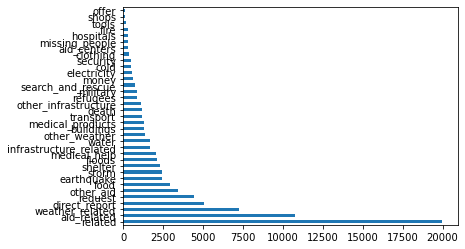

In [12]:
sums_categories.plot.barh()

In [10]:
Y.isnull().sum().any()

False

### 2. Write a tokenization function to process your text data

In [5]:
def tokenize(text):
    url_regex = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    detected_urls = re.findall(url_regex, text)
    for url in detected_urls:
        text = text.replace(url, "urlplaceholder")

    tokens = word_tokenize(text)
    lemmatizer = WordNetLemmatizer()

    clean_tokens = []
    for tok in tokens:
        clean_tok = lemmatizer.lemmatize(tok).lower().strip()
        clean_tokens.append(clean_tok)

    return clean_tokens

### 3. Build a machine learning pipeline
This machine pipeline should take in the `message` column as input and output classification results on the other 36 categories in the dataset. You may find the [MultiOutputClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html) helpful for predicting multiple target variables.

## Start with LogisticRegression with class_weight='balanced' as classes are imbalanced

In [12]:
pipeline = Pipeline([
    ('vector', CountVectorizer(tokenizer=tokenize)),
    ('tfidf', TfidfTransformer()),
    ('clf', MultiOutputClassifier(LogisticRegression(class_weight='balanced', n_jobs=-1),n_jobs=-1))
])

### 4. Train pipeline
- Split data into train and test sets
- Train pipeline

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.2)

In [ ]:
pipeline.fit(X_train, y_train)

### 5. Test your model
Report the f1 score, precision and recall for each output category of the dataset. You can do this by iterating through the columns and calling sklearn's `classification_report` on each.

In [6]:
# for each category of labels (each column of Y) 
    #   1 print out classification_report
    #   2 compute f1 score for the positive class (value = 1)
    # then compute an average of all the f1 scores (global_f1_score)
def check_results(y_test, y_pred, to_print=False):
    f1_array = []
    for index, column in enumerate(y_test.columns):
        prediction = y_pred[:,index]
        actual = y_test.iloc[:,index]
        if to_print:
            print('Category = {}'.format(column))
            print(classification_report(actual, prediction))
            #print(precision_recall_fscore_support(actual, prediction, average='binary'))
        f1 = f1_score(actual, prediction)
        f1_array.append(f1)
    global_f1_score = np.mean(f1_array)
    if to_print:
        print('Arithmetic mean of f1 scores for each category = {}'.format(round(global_f1_score,2)))
    return global_f1_score

## Created a custom scorer, but it turned out to be the same as 'f1_macro' scorer option 

In [15]:
# create a custom scorer function based on the above 
f1_custom_scorer = make_scorer(check_results, to_print=False)

In [16]:
y_pred = pipeline.predict(X_test)

In [17]:
check_results(y_test, y_pred, True)

Category = related
              precision    recall  f1-score   support

         0.0       0.32      0.49      0.39      1219
         1.0       0.81      0.69      0.74      3989

    accuracy                           0.64      5208
   macro avg       0.57      0.59      0.57      5208
weighted avg       0.70      0.64      0.66      5208

Category = request
              precision    recall  f1-score   support

         0.0       0.91      0.76      0.83      4332
         1.0       0.35      0.63      0.45       876

    accuracy                           0.74      5208
   macro avg       0.63      0.70      0.64      5208
weighted avg       0.82      0.74      0.76      5208

Category = offer
              precision    recall  f1-score   support

         0.0       1.00      0.99      1.00      5190
         1.0       0.03      0.06      0.04        18

    accuracy                           0.99      5208
   macro avg       0.51      0.52      0.52      5208
weighted avg       

              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00      5181
         1.0       0.00      0.00      0.00        27

    accuracy                           0.99      5208
   macro avg       0.50      0.50      0.50      5208
weighted avg       0.99      0.99      0.99      5208

Category = aid_centers
              precision    recall  f1-score   support

         0.0       0.99      0.98      0.98      5139
         1.0       0.02      0.03      0.02        69

    accuracy                           0.97      5208
   macro avg       0.50      0.50      0.50      5208
weighted avg       0.97      0.97      0.97      5208

Category = other_infrastructure
              precision    recall  f1-score   support

         0.0       0.96      0.87      0.91      4980
         1.0       0.05      0.14      0.07       228

    accuracy                           0.84      5208
   macro avg       0.50      0.51      0.49      5208
weighted avg       

0.16034357490021223

## The average f1 score for basic Logistic Regression is only 0.15 due to imbalanced classes 

### 6. Improve your model
Use grid search to find better parameters. 

In [18]:
pipeline.get_params()

{'memory': None,
 'steps': [('vector',
   CountVectorizer(tokenizer=<function tokenize at 0x1a23a1d050>)),
  ('tfidf', TfidfTransformer()),
  ('clf',
   MultiOutputClassifier(estimator=LogisticRegression(class_weight='balanced',
                                                      n_jobs=-1),
                         n_jobs=-1))],
 'verbose': False,
 'vector': CountVectorizer(tokenizer=<function tokenize at 0x1a23a1d050>),
 'tfidf': TfidfTransformer(),
 'clf': MultiOutputClassifier(estimator=LogisticRegression(class_weight='balanced',
                                                    n_jobs=-1),
                       n_jobs=-1),
 'vector__analyzer': 'word',
 'vector__binary': False,
 'vector__decode_error': 'strict',
 'vector__dtype': numpy.int64,
 'vector__encoding': 'utf-8',
 'vector__input': 'content',
 'vector__lowercase': True,
 'vector__max_df': 1.0,
 'vector__max_features': None,
 'vector__min_df': 1,
 'vector__ngram_range': (1, 1),
 'vector__preprocessor': None,
 'vector__s

In [19]:
parameters = {
    #'vector__max_df' : [1],
    'vector__ngram_range': [(1,1), (1,2)]
    #'tfidf__use_idf': [True, False],
    #'vector__stop_words': [None, 'english'],
    #'clf__estimator__learning_rate': [0.5, 1],
    #'clf__estimator__n_estimators': [50, 75],
    #'clf__estimator__max_iter': [100],
    #'clf__estimator__penalty': ['l1','l2'],
    #'clf__estimator__tol': [0.0001]
}

cv = GridSearchCV(pipeline, param_grid = parameters, n_jobs=-1, cv=3, scoring='f1_macro')
cv.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('vector',
                                        CountVectorizer(tokenizer=<function tokenize at 0x1a23a1d050>)),
                                       ('tfidf', TfidfTransformer()),
                                       ('clf',
                                        MultiOutputClassifier(estimator=LogisticRegression(class_weight='balanced',
                                                                                           n_jobs=-1),
                                                              n_jobs=-1))]),
             n_jobs=-1, param_grid={'vector__ngram_range': [(1, 1), (1, 2)]},
             scoring='f1_macro')

In [20]:
print(cv.best_params_)

{'vector__ngram_range': (1, 1)}


### 7. Test your model
Show the accuracy, precision, and recall of the tuned model.  

Since this project focuses on code quality, process, and  pipelines, there is no minimum performance metric needed to pass. However, make sure to fine tune your models for accuracy, precision and recall to make your project stand out - especially for your portfolio!

In [21]:
y_pred = cv.predict(X_test)
check_results(y_test, y_pred, True)

Category = related
              precision    recall  f1-score   support

         0.0       0.32      0.49      0.39      1219
         1.0       0.81      0.69      0.74      3989

    accuracy                           0.64      5208
   macro avg       0.57      0.59      0.57      5208
weighted avg       0.70      0.64      0.66      5208

Category = request
              precision    recall  f1-score   support

         0.0       0.91      0.76      0.83      4332
         1.0       0.35      0.63      0.45       876

    accuracy                           0.74      5208
   macro avg       0.63      0.70      0.64      5208
weighted avg       0.82      0.74      0.76      5208

Category = offer
              precision    recall  f1-score   support

         0.0       1.00      0.99      1.00      5190
         1.0       0.03      0.06      0.04        18

    accuracy                           0.99      5208
   macro avg       0.51      0.52      0.52      5208
weighted avg       

              precision    recall  f1-score   support

         0.0       0.94      0.78      0.85      4788
         1.0       0.13      0.39      0.20       420

    accuracy                           0.75      5208
   macro avg       0.53      0.58      0.52      5208
weighted avg       0.87      0.75      0.80      5208

Category = storm
              precision    recall  f1-score   support

         0.0       0.94      0.84      0.89      4731
         1.0       0.22      0.45      0.30       477

    accuracy                           0.81      5208
   macro avg       0.58      0.65      0.59      5208
weighted avg       0.87      0.81      0.83      5208

Category = fire
              precision    recall  f1-score   support

         0.0       0.99      0.98      0.98      5143
         1.0       0.04      0.06      0.05        65

    accuracy                           0.97      5208
   macro avg       0.51      0.52      0.51      5208
weighted avg       0.98      0.97      0.

0.16034357490021223

### 8. Try improving your model further. Here are a few ideas:
* try other machine learning algorithms
* add other features besides the TF-IDF

## Trying AdaBoost 

In [7]:
pipeline_ada = Pipeline([
    ('vector', CountVectorizer(tokenizer=tokenize)),
    ('tfidf', TfidfTransformer()),
    ('clf', MultiOutputClassifier(AdaBoostClassifier(
                    base_estimator=DecisionTreeClassifier(max_depth=1, class_weight='balanced')
                )
            )
    )
])

In [26]:
pipeline_ada.fit(X_train, y_train)

Pipeline(steps=[('vector',
                 CountVectorizer(tokenizer=<function tokenize at 0x1a23a1d050>)),
                ('tfidf', TfidfTransformer()),
                ('clf',
                 MultiOutputClassifier(estimator=AdaBoostClassifier(base_estimator=DecisionTreeClassifier(class_weight='balanced',
                                                                                                          max_depth=1))))])

In [27]:
y_pred_ada = pipeline_ada.predict(X_test)

In [28]:
check_results(y_test, y_pred_ada, True)

Category = related
              precision    recall  f1-score   support

         0.0       0.30      0.45      0.36      1219
         1.0       0.80      0.68      0.74      3989

    accuracy                           0.63      5208
   macro avg       0.55      0.57      0.55      5208
weighted avg       0.69      0.63      0.65      5208

Category = request
              precision    recall  f1-score   support

         0.0       0.91      0.70      0.79      4332
         1.0       0.31      0.68      0.43       876

    accuracy                           0.69      5208
   macro avg       0.61      0.69      0.61      5208
weighted avg       0.81      0.69      0.73      5208

Category = offer
              precision    recall  f1-score   support

         0.0       1.00      0.88      0.93      5190
         1.0       0.00      0.17      0.01        18

    accuracy                           0.87      5208
   macro avg       0.50      0.52      0.47      5208
weighted avg       

              precision    recall  f1-score   support

         0.0       0.97      0.53      0.68      4980
         1.0       0.06      0.66      0.11       228

    accuracy                           0.53      5208
   macro avg       0.52      0.59      0.40      5208
weighted avg       0.93      0.53      0.66      5208

Category = weather_related
              precision    recall  f1-score   support

         0.0       0.77      0.84      0.81      3750
         1.0       0.47      0.36      0.41      1458

    accuracy                           0.71      5208
   macro avg       0.62      0.60      0.61      5208
weighted avg       0.69      0.71      0.69      5208

Category = floods
              precision    recall  f1-score   support

         0.0       0.95      0.59      0.73      4788
         1.0       0.13      0.68      0.21       420

    accuracy                           0.60      5208
   macro avg       0.54      0.63      0.47      5208
weighted avg       0.89      

0.159127925610972

## The results for AdaBoost are better than for the Logistic Regression 

In [29]:
pipeline_ada.get_params()

{'memory': None,
 'steps': [('vector',
   CountVectorizer(tokenizer=<function tokenize at 0x1a23a1d050>)),
  ('tfidf', TfidfTransformer()),
  ('clf',
   MultiOutputClassifier(estimator=AdaBoostClassifier(base_estimator=DecisionTreeClassifier(class_weight='balanced',
                                                                                            max_depth=1))))],
 'verbose': False,
 'vector': CountVectorizer(tokenizer=<function tokenize at 0x1a23a1d050>),
 'tfidf': TfidfTransformer(),
 'clf': MultiOutputClassifier(estimator=AdaBoostClassifier(base_estimator=DecisionTreeClassifier(class_weight='balanced',
                                                                                          max_depth=1))),
 'vector__analyzer': 'word',
 'vector__binary': False,
 'vector__decode_error': 'strict',
 'vector__dtype': numpy.int64,
 'vector__encoding': 'utf-8',
 'vector__input': 'content',
 'vector__lowercase': True,
 'vector__max_df': 1.0,
 'vector__max_features': None,
 'vector

In [30]:
parameters = {
    #'vector__max_df' : [0.5, 1],
    #'vector__ngram_range': [(1,1), (1,2)],
    #'tfidf__use_idf': [True, False],
    #'vector__stop_words': [None, 'english'],
    'clf__estimator__learning_rate': [0.5, 1]
    #'clf__estimator__n_estimators': [50, 75],
    #'clf__estimator__base_estimator__max_depth': [1,2]
    #'clf__estimator__max_iter': [100],
    #'clf__estimator__penalty': ['l1','l2'],
    #'clf__estimator__tol': [0.0001]
}

cv_ada_2 = GridSearchCV(pipeline_ada, param_grid = parameters, n_jobs=-1, cv=3, scoring='f1_macro')
cv_ada_2.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('vector',
                                        CountVectorizer(tokenizer=<function tokenize at 0x1a23a1d050>)),
                                       ('tfidf', TfidfTransformer()),
                                       ('clf',
                                        MultiOutputClassifier(estimator=AdaBoostClassifier(base_estimator=DecisionTreeClassifier(class_weight='balanced',
                                                                                                                                 max_depth=1))))]),
             n_jobs=-1, param_grid={'clf__estimator__learning_rate': [0.5, 1]},
             scoring='f1_macro')

In [31]:
print(cv_ada_2.best_params_)
print(cv_ada_2.best_score_)

{'clf__estimator__learning_rate': 0.5}
0.1631318827446357


In [32]:
print(cv_ada_2.best_estimator_)

Pipeline(steps=[('vector',
                 CountVectorizer(tokenizer=<function tokenize at 0x1a23a1d050>)),
                ('tfidf', TfidfTransformer()),
                ('clf',
                 MultiOutputClassifier(estimator=AdaBoostClassifier(base_estimator=DecisionTreeClassifier(class_weight='balanced',
                                                                                                          max_depth=1),
                                                                    learning_rate=0.5)))])


In [33]:
y_pred_cv_ada  = cv_ada_2.predict(X_test)
check_results(y_test, y_pred_cv_ada, True)

Category = related
              precision    recall  f1-score   support

         0.0       0.31      0.45      0.36      1219
         1.0       0.80      0.69      0.74      3989

    accuracy                           0.63      5208
   macro avg       0.56      0.57      0.55      5208
weighted avg       0.69      0.63      0.65      5208

Category = request
              precision    recall  f1-score   support

         0.0       0.92      0.70      0.80      4332
         1.0       0.32      0.69      0.44       876

    accuracy                           0.70      5208
   macro avg       0.62      0.70      0.62      5208
weighted avg       0.82      0.70      0.74      5208

Category = offer
              precision    recall  f1-score   support

         0.0       1.00      0.72      0.84      5190
         1.0       0.01      0.50      0.01        18

    accuracy                           0.72      5208
   macro avg       0.50      0.61      0.43      5208
weighted avg       

Category = shops
              precision    recall  f1-score   support

         0.0       1.00      0.71      0.83      5181
         1.0       0.01      0.33      0.01        27

    accuracy                           0.71      5208
   macro avg       0.50      0.52      0.42      5208
weighted avg       0.99      0.71      0.83      5208

Category = aid_centers
              precision    recall  f1-score   support

         0.0       0.99      0.64      0.77      5139
         1.0       0.02      0.45      0.03        69

    accuracy                           0.63      5208
   macro avg       0.50      0.54      0.40      5208
weighted avg       0.98      0.63      0.76      5208

Category = other_infrastructure
              precision    recall  f1-score   support

         0.0       0.98      0.47      0.64      4980
         1.0       0.06      0.77      0.12       228

    accuracy                           0.48      5208
   macro avg       0.52      0.62      0.38      5208
we

0.16902071612799957

In [34]:
# checked to see if custom scorer and f1_macro is the same thing
f1_score(y_test, y_pred_cv_ada, average='macro')

0.16902071612799957

## Improving on the previous step

In [11]:
parameters = {
    #'vector__max_df' : [0.5, 1],
    #'vector__ngram_range': [(1,1), (1,2)],
    #'tfidf__use_idf': [True, False],
    #'vector__stop_words': [None, 'english'],
    'clf__estimator__learning_rate': [0.2, 0.3],
    'clf__estimator__n_estimators': [100,200]
    #'clf__estimator__base_estimator__max_depth': [1,2]
    #'clf__estimator__max_iter': [100],
    #'clf__estimator__penalty': ['l1','l2'],
    #'clf__estimator__tol': [0.0001]
}

cv_ada_3 = GridSearchCV(pipeline_ada, param_grid = parameters, n_jobs=-1, cv=3, scoring='f1_macro')
cv_ada_3.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('vector',
                                        CountVectorizer(tokenizer=<function tokenize at 0x1a27755320>)),
                                       ('tfidf', TfidfTransformer()),
                                       ('clf',
                                        MultiOutputClassifier(estimator=AdaBoostClassifier(base_estimator=DecisionTreeClassifier(class_weight='balanced',
                                                                                                                                 max_depth=1))))]),
             n_jobs=-1,
             param_grid={'clf__estimator__learning_rate': [0.2, 0.3],
                         'clf__estimator__n_estimators': [100, 200]},
             scoring='f1_macro')

In [13]:
print(cv_ada_3.best_params_)

{'clf__estimator__learning_rate': 0.2, 'clf__estimator__n_estimators': 100}


In [14]:
y_pred_cv_ada  = cv_ada_3.predict(X_test)
print(f1_score(y_test, y_pred_cv_ada, average='macro'))
print(f1_score(y_test, y_pred_cv_ada, average='micro'))
check_results(y_test, y_pred_cv_ada, True)

0.1682290273545908
0.21159666593467452
Category = related
              precision    recall  f1-score   support

         0.0       0.31      0.46      0.37      1232
         1.0       0.80      0.69      0.74      3976

    accuracy                           0.63      5208
   macro avg       0.56      0.57      0.56      5208
weighted avg       0.69      0.63      0.65      5208

Category = request
              precision    recall  f1-score   support

         0.0       0.93      0.69      0.79      4322
         1.0       0.33      0.74      0.46       886

    accuracy                           0.70      5208
   macro avg       0.63      0.72      0.63      5208
weighted avg       0.83      0.70      0.74      5208

Category = offer
              precision    recall  f1-score   support

         0.0       1.00      0.73      0.84      5179
         1.0       0.01      0.66      0.03        29

    accuracy                           0.73      5208
   macro avg       0.51      0.69 

              precision    recall  f1-score   support

         0.0       0.96      0.55      0.70      4768
         1.0       0.13      0.77      0.23       440

    accuracy                           0.57      5208
   macro avg       0.55      0.66      0.46      5208
weighted avg       0.89      0.57      0.66      5208

Category = storm
              precision    recall  f1-score   support

         0.0       0.95      0.54      0.69      4703
         1.0       0.14      0.71      0.24       505

    accuracy                           0.56      5208
   macro avg       0.55      0.63      0.47      5208
weighted avg       0.87      0.56      0.65      5208

Category = fire
              precision    recall  f1-score   support

         0.0       0.99      0.57      0.72      5150
         1.0       0.01      0.47      0.02        58

    accuracy                           0.57      5208
   macro avg       0.50      0.52      0.37      5208
weighted avg       0.98      0.57      0.

0.1682290273545908

### 9. Export your model as a pickle file

In [38]:
model = cv_ada_3.best_estimator_
filename = 'ava_model_3.pkl'
pickle.dump(model, open(filename, 'wb'))

### 10. Use this notebook to complete `train.py`
Use the template file attached in the Resources folder to write a script that runs the steps above to create a database and export a model based on a new dataset specified by the user.